/var/folders/vm/_zft15050r7cfh47y6v5z4k40000gn/T/ipykernel_46476/2773871201.py:88: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[col].fillna(method="ffill", inplace=True)


起始時間: 2008-01-02 00:00:00
結束時間: 2024-04-03 00:00:00
單次投入金額: 20000
投入次數: 196
總投入本金: 3920000
最後投資價值: 11771562
每次投入的IRR:0.97%


/var/folders/vm/_zft15050r7cfh47y6v5z4k40000gn/T/ipykernel_46476/2773871201.py:88: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[col].fillna(method="ffill", inplace=True)


起始時間: 1980-12-12 00:00:00
結束時間: 2024-04-04 00:00:00
單次投入金額: 1000
投入次數: 521
總投入本金: 521000
最後投資價值: 288291488
每次投入的IRR:1.63%


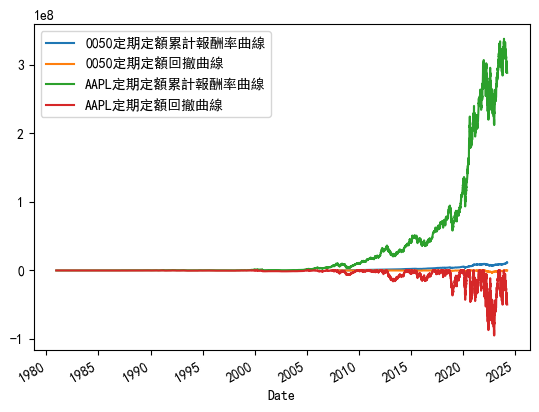

In [13]:
"""
定期定額投資實作
pip install numpy_financial
"""

# 載入函數工具檔
import pandas as pd
# matplotlib
import matplotlib.pyplot as plt
# 以下為自訂函數「getDataYF」「getDataFM」使用
import os
import yfinance as yf
import numpy_financial as npf
# 忽略警告
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# 配置 matplotlib 的字體為支援中文的字體
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 例如使用微軟雅黑
plt.rcParams["axes.unicode_minus"] = False  # 正確顯示負號


def getDataYF(prod):
    # 備份文件的資料夾
    folder_name = "data"
    # 檢查資料夾是否存在
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # 1. 定義備份檔案名稱
    bakfile = os.path.join(folder_name, f"yf_{prod}.csv")
    # 2. 檢視是否有歷史資料(本地端)
    if os.path.exists(bakfile):
        yfdata = pd.read_csv(bakfile)
        yfdata["Date"] = pd.to_datetime(yfdata["Date"], format="%Y-%m-%d")
        yfdata.set_index("Date", inplace=True)
    else:
        # 最大範圍
        yfdata = yf.download(prod, period="max")
        # 也可以指定起迄日期
        # yfdata = yf.download(str(prod), start='2020-01-01', end='2024-03-31')
        yfdata.columns = [i.lower() for i in yfdata.columns]
        # 上網下載後 存到本地端
        yfdata.to_csv(bakfile)
    return yfdata


def getDataFM(prod):
    # 備份文件的資料夾
    folder_name = "data"
    # 檢查資料夾是否存在
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # 1. 定義備份檔案名稱
    bakfile = os.path.join(folder_name, f"{prod}.csv")
    # 2. 檢視是否有歷史資料(本地端)
    if os.path.exists(bakfile):
        yfdata = pd.read_csv(bakfile)
        yfdata["Date"] = pd.to_datetime(yfdata["Date"], format="%Y-%m-%d")
        yfdata.set_index("Date", inplace=True)
    else:
        yfdata = yf.download(f"{prod}.TW", period="max", progress=False)
        if yfdata.shape[0] == 0:
            yfdata = yf.download(f"{prod}.TWO", period="max", progress=False)
        yfdata.columns = [i.lower() for i in yfdata.columns]
        # 上網下載後 存到本地端
        yfdata.to_csv(bakfile)
    return yfdata


# 計算定期定額報酬率以及繪製權益曲線圖
def ReturnRegularFixedInvestment(
    getDataFunction, symbol, price_column, once_amount
):
    # 取得商品資料
    data = getDataFunction(symbol)
    data["ret"] = data[price_column].pct_change().copy()
    data["cap_ret"] = 1 + data["ret"].copy()

    # 將日期變成欄位 方便後續判斷
    data["today"] = data.index.copy()
    data["yesterday"] = data["today"].shift(1).copy()

    # 每個月投入金額
    inv_time = 0
    inv_action = []
    data = data.copy()
    for index, row in data.iterrows():
        # 換月定期定額投資
        if row["yesterday"].month != row["today"].month:
            data.loc[index, "inv_%s" % (inv_time)] = once_amount
            inv_time += 1
            inv_action.append(-once_amount)
    # 抓出定期定額的投資欄位 計算期末本金
    inv_col = [i for i in data.columns if i[:3] == "inv"]
    for col in inv_col:
        data[col].fillna(method="ffill", inplace=True)
        data[col] *= data.loc[
            data[col].notna(), "cap_ret"
        ].iloc[1:].cumprod().copy()
    data["final_cap"] = data[inv_col].sum(axis=1).copy()

    # 計算內部報酬率
    inv_action.append(data["final_cap"].iloc[-1])

    # 顯示定期定額 細節
    print(f"起始時間: {data.index[0]}")
    print(f"結束時間: {data.index[-1]}")
    print(f"單次投入金額: {once_amount}")
    print(f"投入次數: {inv_time}")
    print(f"總投入本金: {once_amount * inv_time}")
    print(f"最後投資價值: {int(data['final_cap'].iloc[-1])}")
    print(f"每次投入的IRR:{round(npf.irr(inv_action) * 100, 2)}%")

    # 繪製權益曲線、回圖
    data["final_cap"].plot(label=f"{symbol}定期定額累計報酬率曲線", legend=True)
    (data["final_cap"] - data["final_cap"].cummax()).plot(
        label=f"{symbol}定期定額回撤曲線", legend=True
    )


# 計算台股定期定額報酬
ReturnRegularFixedInvestment(getDataFM, "0050", "adj close", 20000)

# 計算美股定期定額報酬
ReturnRegularFixedInvestment(getDataYF, "AAPL", "adj close", 1000)
